In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, auc
import lightgbm as lgb
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb

In [63]:
metadata = pd.read_csv("metadata.csv",header=0,index_col=0)
microbiome = pd.read_csv("microbiome.csv",header=0,index_col=0)
metabolome = pd.read_csv("serum_lipo.csv",header=0,index_col=0)

In [64]:
def clr_transform(df: pd.DataFrame, epsilon=1e-6) -> pd.DataFrame:
    X = df.fillna(0.0).astype(float).values
    X = np.log(X+epsilon)
    X = X - X.mean(axis=1, keepdims=True)
    return pd.DataFrame(X, index=df.index, columns=df.columns)
def standartization_transform(train_df, test_df):
    scaler = StandardScaler().fit(train_df)
    train_scaled = pd.DataFrame(scaler.transform(train_df), index=train_df.index, columns=train_df.columns)
    test_scaled = pd.DataFrame(scaler.transform(test_df), index=test_df.index, columns=test_df.columns)
    return train_scaled, test_scaled

In [65]:
diseases_to_categories = {'Metabolic_Syndrome':['1'],'Type_2_Diabetes':['3'],'Coronary_Artery_Disease':['4','5','6'],'Severe_Obesity':['2a','2b'],'Heart_Failure':['6','7'],'Healthy':['8']}
microbiome_train, microbiome_test, diseases_train, diseases_test = train_test_split(microbiome, metadata[['PATGROUPFINAL_C']], train_size=0.8)
microbiome_train = clr_transform(microbiome_train)
microbiome_test = clr_transform(microbiome_test)
train_indices = microbiome_train.index
test_indices  = microbiome_test.index
metabolome_train = metabolome.loc[train_indices]
metabolome_test  = metabolome.loc[test_indices]
metabolome_train, metabolome_test = standartization_transform(metabolome_train, metabolome_test)
microbiome_and_metabolome_train = pd.merge(metabolome_train, microbiome_train, left_index=True, right_index=True, how='inner')
microbiome_and_metabolome_test = pd.merge(metabolome_test, microbiome_test, left_index=True, right_index=True, how='inner')
metadata['Disease_status'] = metadata['PATGROUPFINAL_C'].apply(lambda x:0 if x == '8' else 1)
metadata_train = metadata.loc[train_indices]
metadata_test = metadata.loc[test_indices]
labels_train_all_diseases = metadata_train['Disease_status']
labels_test_all_diseases = metadata_test['Disease_status']

In [66]:
def run_bagged_random_forest(train_data, train_labels, test_data):
    rand = np.random.default_rng()
    # labels: 0 = healthy, 1 = sick
    healthy_indices = np.where(train_labels == 0)[0]
    sick_indices    = np.where(train_labels == 1)[0]
    n_bags = 60
    target_sick_ratio = 0.10

    # Options for model to increase diversity between bags
    bag_size_low  = 150
    bag_size_high = 250
    max_features_pool   = ["sqrt", 0.2, 0.33, 0.5]
    max_depth_pool      = [4, 6, 8, 10, 12, None]
    min_samples_leaf_pool = [1, 2, 3, 4, 5, 6]

    probs_train_sum = np.zeros(len(train_labels), dtype=float)
    probs_test_sum  = np.zeros(len(test_data), dtype=float)
    probs_train_bags = []
    probs_test_bags  = []

    for b in range(n_bags):
        # Different bag size each time
        bag_size = int(rand.integers(bag_size_low, bag_size_high + 1))
        n_sick_bag    = max(1, int(round(target_sick_ratio * bag_size)))
        n_healthy_bag = max(1, bag_size - n_sick_bag)

        # Sampling to have 90% healthy 10% sick inside each bag
        sick_sample = rand.choice(
            sick_indices,
            size=n_sick_bag,
            replace=(n_sick_bag > len(sick_indices))
        )
        healthy_sample = rand.choice(
            healthy_indices,
            size=n_healthy_bag,
            replace=True
        )

        bag_indices = np.concatenate([healthy_sample, sick_sample])
        rand.shuffle(bag_indices)

        data_bag   = train_data.iloc[bag_indices]
        labels_bag = train_labels.iloc[bag_indices]

        # Choose model hyperparameters for current bag
        max_features_choice   = max_features_pool[int(rand.integers(0, len(max_features_pool)))]
        max_depth_choice      = max_depth_pool[int(rand.integers(0, len(max_depth_pool)))]
        min_samples_leaf_choice = min_samples_leaf_pool[int(rand.integers(0, len(min_samples_leaf_pool)))]

        model = RandomForestClassifier(
            n_estimators=200,
            class_weight="balanced_subsample",
            max_features=max_features_choice,
            max_depth=max_depth_choice,
            min_samples_leaf=min_samples_leaf_choice,
        )
        model.fit(data_bag, labels_bag)

        # Prediction probabilities per bag
        probs_train = model.predict_proba(train_data)[:, 1]
        probs_test  = model.predict_proba(test_data)[:, 1]

        probs_train_sum += probs_train
        probs_test_sum  += probs_test

        probs_train_bags.append(probs_train)
        probs_test_bags.append(probs_test)

    # Average probabilities across bags
    probs_train_mean = probs_train_sum / n_bags
    probs_test_mean  = probs_test_sum  / n_bags

    probs_train_bags = np.vstack(probs_train_bags)
    probs_test_bags  = np.vstack(probs_test_bags)
    
    return probs_train_mean, probs_test_mean, probs_train_bags, probs_test_bags

In [67]:
def aupr_balanced(labels: np.ndarray, pred_probs: np.ndarray) -> float:
    """
    Compute AUPR adjusted to simulate 10% positives and 90% negatives
    using sample weights, without discarding any samples.
    """
    sick_indices = labels == 1
    healthy_indices = labels == 0
    sick_num = sick_indices.sum()
    healthy_num = healthy_indices.sum()
    
    target_ratio = 0.1
    w_sick = 1.0
    w_healthy = (w_sick * sick_num * (1 - target_ratio)) / (target_ratio * healthy_num)
    
    # Assign weights per sample
    weights = np.ones_like(labels, dtype=float)
    weights[sick_indices] = w_sick
    weights[healthy_indices] = w_healthy
    
    precision, recall, _ = precision_recall_curve(labels, pred_probs, sample_weight=weights)
    baseline = np.sum(weights[sick_indices]) / np.sum(weights)
    aupr = auc(recall, precision)

    plt.figure(figsize=(8, 5))
    plt.plot(recall, precision, label=f'AUPR = {aupr:.4f}')
    plt.hlines(baseline, 0, 1, colors='r', linestyles='dashed', label=f'Baseline = {baseline:.4f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Weighted Precision-Recall Curve (at 10% sick)')
    plt.legend()
    plt.tight_layout()
    plt.show()
    return aupr

In [68]:
def first_layer(train_data, train_labels, test_data, test_labels):
    train_probs, test_probs, train_probs_bags, test_probs_bags = run_bagged_random_forest(train_data, train_labels, test_data)
    print("AUPR of first layer only is: ",aupr_balanced(test_labels, test_probs))

    std_train = train_probs_bags.std(axis=0)
    std_test = test_probs_bags.std(axis=0)
    prob_lower, prob_upper = np.quantile(train_probs, [0.15, 0.85])
    std_threshold = np.quantile(std_train, 0.4)

    certain_test_samples_mask = ((test_probs <= prob_lower) | (test_probs >= prob_upper)) & (std_test <= std_threshold)
    uncertain_test_samples_mask = ~certain_test_samples_mask
    certain_indices = np.where(certain_test_samples_mask)[0]
    uncertain_indices  = np.where(uncertain_test_samples_mask)[0]
    test_labels_uncertain = test_labels.iloc[uncertain_indices]
    test_uncertain = test_data.iloc[uncertain_indices]
    test_labels_certain = test_labels[certain_indices]
    test_probs_certain = test_probs[certain_indices]
    return test_uncertain, test_labels_uncertain, test_labels_certain, test_probs_certain

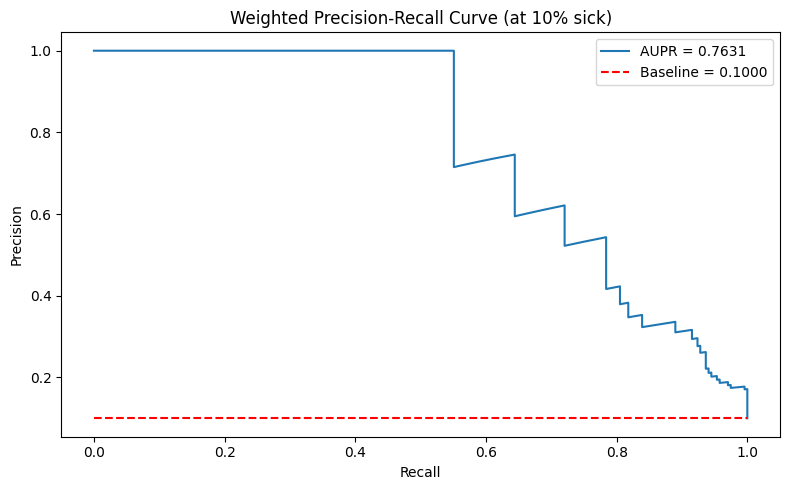

AUPR of first layer only is:  0.7630607841404574


In [69]:
test_uncertain, test_labels_uncertain, test_labels_certain, test_probs_certain = first_layer(microbiome_and_metabolome_train, labels_train_all_diseases, microbiome_and_metabolome_test, labels_test_all_diseases)

In [70]:
def run_lgbm_with_reweighting(train_data, train_labels, test_data):
    """
    Fits a LightGBM classifier with sample weights to correct for class imbalance.
    The function assumes an initial distribution of 90% sick / 10% healthy in the training data
    and re-weights it to a target of 10% sick / 90% healthy.
    """
    target_ratio = 0.1
    sick_indices = train_labels == 1
    healthy_indices = train_labels == 0
    sick_num = sick_indices.sum()
    healthy_num = healthy_indices.sum()

    w_sick = 1.0
    w_healthy = (w_sick * sick_num * (1 - target_ratio)) / (target_ratio * healthy_num)
    
    # Assign weights per sample
    weights = np.ones_like(train_labels, dtype=float)
    weights[sick_indices] = w_sick
    weights[healthy_indices] = w_healthy

    lgbm = lgb.LGBMClassifier(objective='binary', verbose=-1)
    lgbm.fit(train_data, train_labels, sample_weight=weights)

    probs_test_uncertain = lgbm.predict_proba(test_data)[:, 1]
    return probs_test_uncertain

In [71]:
def second_layer():
    # Run the model on the uncertain data from the first layer
    probs_uncertain = run_lgbm_with_reweighting(
        microbiome_and_metabolome_train, 
        labels_train_all_diseases, 
        test_uncertain,
    )

    final_probs = np.zeros_like(labels_test_all_diseases, dtype=float)
    certain_indices = test_labels_certain.index
    uncertain_indices = test_labels_uncertain.index
    mask_certain = np.isin(labels_test_all_diseases.index, certain_indices)
    mask_uncertain = np.isin(labels_test_all_diseases.index, uncertain_indices)
    final_probs[mask_certain] = test_probs_certain
    final_probs[mask_uncertain] = probs_uncertain
    print("AUPR for the whole test set after second layer: ", aupr_balanced(labels_test_all_diseases.values, final_probs))

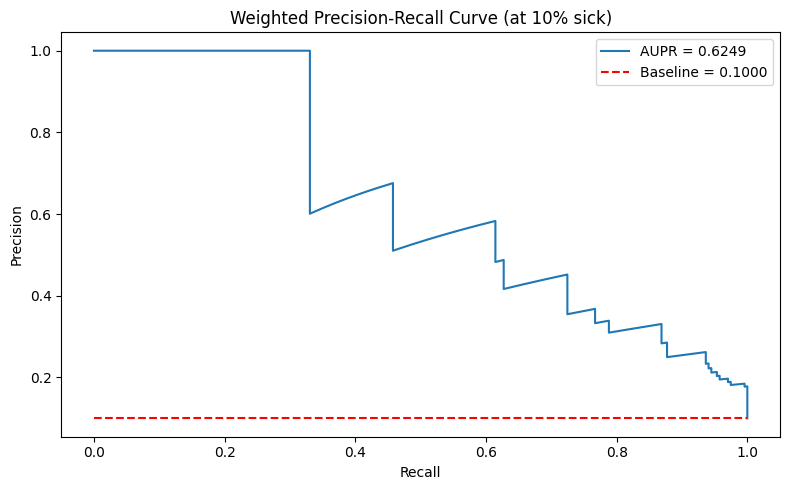

AUPR for the whole test set after second layer:  0.624929064286596


In [72]:
second_layer()